# 구글드라이브 마운트 & Yolov5 설치

In [ ]:
!pip install gdrive_dataset

In [ ]:
from gdrivedataset import loader

#원본 데이터셋 아이디
#file_id = '1tqYoLyWPtKi8tpgIAOagVR11K4Fpo2aL'

#작은 테스트셋
file_id = '1elTKeO_UlbGSugYqrxDf0KRGHoDb1r1d'
loader.load_from_google_drive(file_id)

========== files ============

data/small_light_test_img
data/__MACOSX
data/small_sign_test_img
data/small_peopel_test_img



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content
!git clone https://github.com/ultralytics/yolov5.git

/content
Cloning into 'yolov5'...
remote: Enumerating objects: 16074, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 16074 (delta 5), reused 9 (delta 1), pack-reused 16056
Receiving objects: 100% (16074/16074), 14.63 MiB | 18.73 MiB/s, done.
Resolving deltas: 100% (11037/11037), done.


In [ ]:
%cd /content/yolov5/
!pip install -r requirements.txt

/content/yolov5
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 50.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 645.7/645.7 kB 61.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.1 MB/s eta 0:00:00
  Attempting uninstall: Pillow
    Found existing installation: Pillow 9.4.0
    Uninstalling Pillow-9.4.0:
      Successfully uninstalled Pillow-9.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imageio 2.31.6 requires pillow<10.1.0,>=8.3.2, but you have pillow 10.1.0 which is incompatible.


# 메인 코드
- 저장된 Yolov5 모델 로드
- 원본 이미지 입력후 결과 저장

# 보행자 인식
- 원본 이미지를 좌,우로 5도씩 각 175도 회전시킨 이미지 입력 후 결과 저장
- 원본 이미지에 블러의 강도를 1단계부터 10단계까지 적용시킨 이미지를 입력 후 결과 저장
- 원본 이미지에 밝기를 낮추면서 노이즈를 추가하는 과정을 1단계부터 10단계까지 적용시킨 이미지를 입력 후 결과 저장

In [ ]:
import os
from pathlib import Path
import numpy as np
import cv2
import imutils
import torch
from PIL import Image
from random import randint

class ObjectDetection:
    def __init__(self, weight_path):
        # 모델 로드
        self.model = torch.hub.load('ultralytics/yolov5', 'custom', path=weight_path)

    def detect_objects(self, image):
        results = self.model(image)
        return results

class ImageProcessor:
    def rotate_image(self, image, rotation_angle):
        return imutils.rotate_bound(image, rotation_angle)

    def blurred_image(self, image, kernel, blur_strength):
        return cv2.GaussianBlur(image, kernel, blur_strength)

class PEDAIProcessor:
    def __init__(self, weight_path, image_folder_path, text_folder_path):
        self.object_detector = ObjectDetection(weight_path)
        self.image_processor = ImageProcessor()
        self.image_folder_path = image_folder_path
        self.text_folder_path = text_folder_path
        self.image_files = [f for f in Path(self.image_folder_path).rglob('*') if f.suffix in ['.jpg', '.png', '.jpeg']]

    def load_image_and_get_size(self, image_file): #이미지를 불러오고 이미지의 사이즈 반환
        img = cv2.imread(str(image_file))
        height, width, _ = img.shape
        return img, height, width

    def process_original_images(self): #원본 이미지 객체탐지
        for image_file in self.image_files:
            original_results = []
            # 이미지 로드
            img, height, width = self.load_image_and_get_size(image_file)

            original_results.append(self.object_detector.detect_objects(Image.fromarray(img)))

            original_object_count_list = [len(result.xyxy[0]) for result in original_results]
            original_detection_status_list = ['true' if count > 0 else 'false' for count in original_object_count_list]

            # 결과 저장
            with open(os.path.join(self.text_folder_path, f"{image_file.stem}_PEDAI.txt"), "a") as file:
                file.write("Original Results:\n")
                for status, count in zip(original_detection_status_list, original_object_count_list):
                    file.write(f"{status},{count}\n")

    def rotate_images_and_save_results(self): #이미지를 좌,우로 5도씩 총 180도 회전시켜서 객체 탐지 후 결과 저장
        for image_file in self.image_files:
            left_results = []
            right_results = []
            # 이미지 로드
            img, height, width = self.load_image_and_get_size(image_file)

            for rotation in range(5, 180, 5):
                # 이미지를 좌,우로 5도씩 총 175도 회전
                left_rotated_img = self.image_processor.rotate_image(img.copy(), -rotation)
                right_rotated_img = self.image_processor.rotate_image(img.copy(), rotation)

                #PIL이미지 변환
                left_rotated_pil_img = Image.fromarray(left_rotated_img)
                right_rotated_pil_img = Image.fromarray(right_rotated_img)

                # 모델로 예측
                left_results.append(self.object_detector.detect_objects(left_rotated_pil_img))
                right_results.append(self.object_detector.detect_objects(right_rotated_pil_img))

            left_object_count_list = [len(result.xyxy[0]) for result in left_results]
            left_detection_status_list = ['true' if count > 0 else 'false' for count in left_object_count_list]

            right_object_count_list = [len(result.xyxy[0]) for result in right_results]
            right_detection_status_list = ['true' if count > 0 else 'false' for count in right_object_count_list]

            #결과 저장
            with open(os.path.join(self.text_folder_path, f"{image_file.stem}_PEDAI.txt"), "a") as file:
                file.write("\nLeft Results:\n")
                for status, count in zip(left_detection_status_list, left_object_count_list):
                    file.write(f"{status},{count}\n")

                file.write("\nRight Results:\n")
                for status, count in zip(right_detection_status_list, right_object_count_list):
                    file.write(f"{status},{count}\n")

    def blur_images_and_save_results(self): #블러의 강도를 1부터 10단계로 나눠 원본이미지에 적용 후 객체탐지 후 결과 저장
        for image_file in self.image_files:
            blurred_results = []
            # 이미지 로드
            img, height, width = self.load_image_and_get_size(image_file)

            for blur_strength in range(1, 11):
                # 이미지 블러처리 (강도를 1에서 10까지 변경)
                blurred_img = self.image_processor.blurred_image(img, (21, 21), blur_strength)

                # PIL 이미지로 변환
                blurred_pil_img = Image.fromarray(blurred_img)

                # 모델로 예측
                blurred_results.append(self.object_detector.detect_objects(blurred_pil_img))

                blur_object_count_list = [len(result.xyxy[0]) for result in blurred_results]
                blur_detection_status_list = ['true' if count > 0 else 'false' for count in blur_object_count_list]

            # 결과 저장
            with open(os.path.join(self.text_folder_path, f"{image_file.stem}_PEDAI.txt"), "a") as file:
                file.write("\nBlurred Results:\n")
                for status, count in zip(blur_detection_status_list, blur_object_count_list):
                    file.write(f"{status},{count}\n")

    def add_noise(self, image, brightness_level):
      # 이미지 크기에 따라 노이즈 강도를 계산
      image_height, image_width, _ = image.shape
      total_pixels = image_height * image_width
      max_noise_intensity = total_pixels // 30

      # 밝기 수준에 따라 노이즈 강도를 조절
      noise_intensity = max(1, min(max_noise_intensity, (11 - brightness_level) * total_pixels // 10))

      noisy_image = image.copy()
      for _ in range(noise_intensity):
          x, y = randint(0, image_width - 1), randint(0, image_height - 1)
          noisy_image[y, x] = (randint(0, 255), randint(0, 255), randint(0, 255))  # RGB 랜덤 색상 노이즈 추가
      return noisy_image

    def lower_brightness_and_add_noise_images(self):
        for image_file in self.image_files:
            lower_brightness_and_add_noise_results = []
            # 이미지 로드
            img, height, width = self.load_image_and_get_size(image_file)

            for brightness_level in range(10, 0, -1):
                # 이미지 밝기 조절 (1에서 10까지)
                lower_brightness_img = cv2.convertScaleAbs(img, alpha=(brightness_level / 10))

                # 랜덤 노이즈 추가
                noise_img = self.add_noise(lower_brightness_img, brightness_level)

                # PIL 이미지로 변환
                noise_pil_img = Image.fromarray(noise_img)

                # 모델로 예측
                lower_brightness_and_add_noise_results.append(self.object_detector.detect_objects(noise_pil_img))

                lower_brightness_and_add_noise_object_count_list = \
                 [len(result.xyxy[0]) for result in lower_brightness_and_add_noise_results]
                lower_brightness_and_add_noise_detection_status_list = \
                 ['true' if count > 0 else 'false' for count in lower_brightness_and_add_noise_object_count_list]

            # 결과 저장
            with open(os.path.join(self.text_folder_path, f"{image_file.stem}_PEDAI.txt"), "a") as file:
                file.write("\nBrightness and Noise Results:\n")
                for status, count in zip(lower_brightness_and_add_noise_detection_status_list, lower_brightness_and_add_noise_object_count_list):
                    file.write(f"{status},{count}\n")

    def apply_perspective_transform(self, image, intensity, num):
        # 이미지의 꼭지점 좌표 정의
        rows, cols = image.shape[:2]
        pts1 = np.float32([[0, 0], [0, rows], [cols, 0], [cols, rows]])

        if num == 0:
            # 위쪽으로 돌리기
            offset = int(cols * intensity / 3)
            pts2 = np.float32([[offset, 0], [0, rows], [cols - offset, 0], [cols, rows]])

        elif num == 1:
          # 아래쪽으로 돌리기
            offset = int(cols * intensity / 3)
            pts2 = np.float32([[0, 0], [offset, rows], [cols, 0], [cols - offset, rows]])

        elif num == 2:
            # 오른쪽으로 돌리기
            offset = int(cols * intensity / 4)
            pts2 = np.float32([[0, 0], [0, rows], [cols, offset], [cols, rows - offset]])

        elif num == 3:
            # 왼쪽으로 돌리기
            offset = int(cols * intensity / 4)
            pts2 = np.float32([[0, offset], [0, rows - offset], [cols, 0], [cols, rows]])

        # 원근 변환 행렬 계산
        perspective_matrix = cv2.getPerspectiveTransform(pts1, pts2)

        # 원근 변환 적용
        transformed_img = cv2.warpPerspective(image, perspective_matrix, (cols, rows))

        return transformed_img


    def perspective_transform_and_save_results(self):
        perspective_list = ['Top', 'Bottom', 'Right', 'Left']
        for image_file in self.image_files:
            perspective_transform_transformed_results = []
            # 이미지 로드
            img, height, width = self.load_image_and_get_size(image_file)

            for num in range(4):
                intensity_results = []  # 변환 강도에 대한 결과를 저장할 리스트 초기화

                for intensity in range(1, 11):  # 1부터 10까지의 강도로 변환을 수행
                    # 원근 변환 적용
                    transformed_img = self.apply_perspective_transform(img.copy(), intensity / 10, num)

                    # PIL 이미지로 변환
                    transformed_pil_img = Image.fromarray(transformed_img)

                    # 모델로 예측
                    intensity_results.append(self.object_detector.detect_objects(transformed_pil_img))

                # 결과 저장
                perspective_transform_object_count_list = [len(result.xyxy[0]) for result in intensity_results]
                perspective_transform_detection_status_list = ['true' if count > 0 else 'false' for count in perspective_transform_object_count_list]

                with open(os.path.join(self.text_folder_path, f"{image_file.stem}_PEDAI.txt"), "a") as file:
                    file.write(f"\n{perspective_list[num]} Perspective Transform Results:\n")
                    for status, count in zip(perspective_transform_detection_status_list, perspective_transform_object_count_list):
                        file.write(f"{status},{count}\n")

if __name__ == "__main__":
    weight_path = '/content/drive/MyDrive/위험객체탐지/model/people.pt'
    img_folder_path = '/content/data/small_peopel_test_img'
    txt_folder_path = '/content/drive/MyDrive/위험객체탐지/people_result'

    processor = PEDAIProcessor(weight_path, img_folder_path, txt_folder_path)
    processor.process_original_images()
    processor.rotate_images_and_save_results()
    processor.blur_images_and_save_results()
    processor.lower_brightness_and_add_noise_images()
    processor.perspective_transform_and_save_results()

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-11-21 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 
YOLOv5s summary: 157 layers, 7018216 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


# 변형 이미지 예시

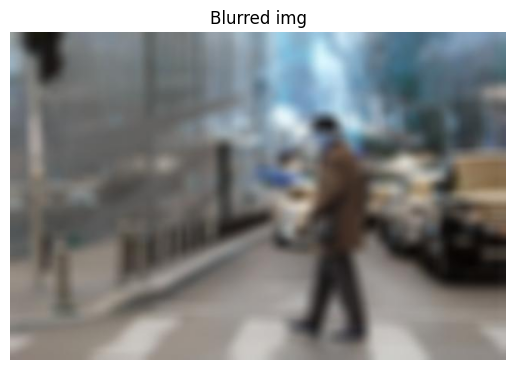

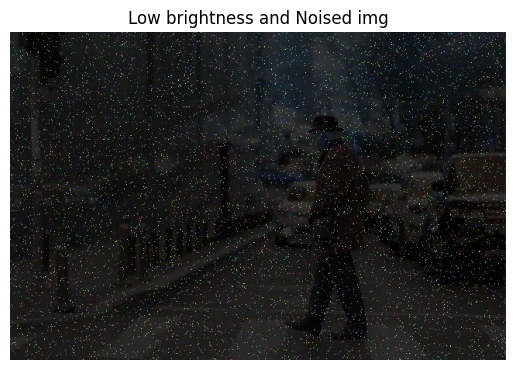

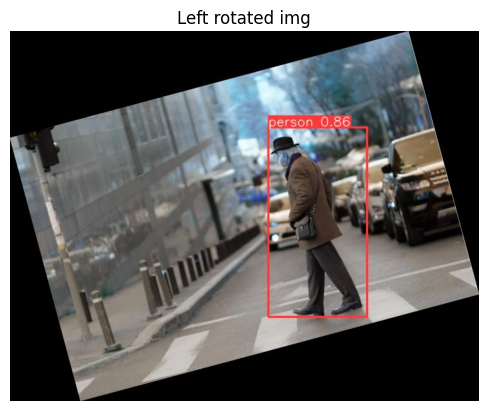

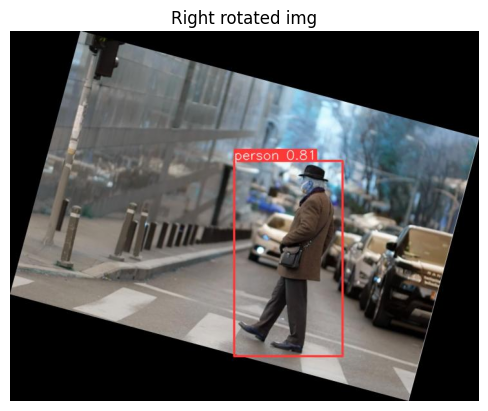

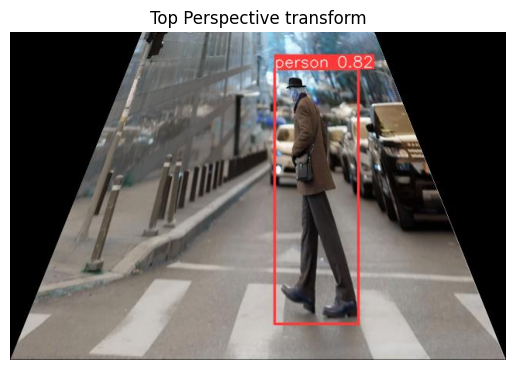

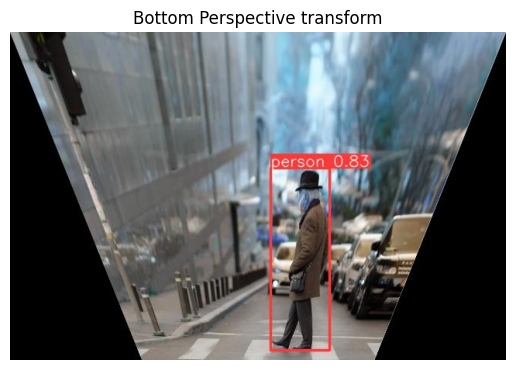

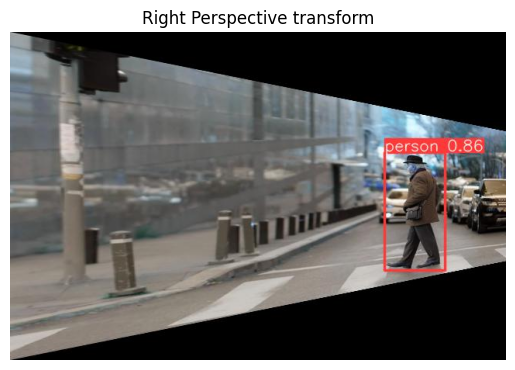

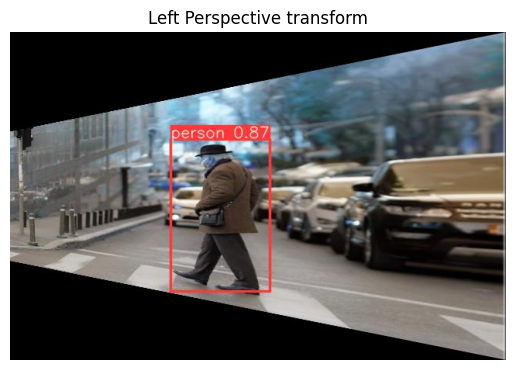

In [ ]:
img_path = '/content/drive/MyDrive/위험객체탐지/임시 결과/보행자1_PEDAI_'

Br = plt.imread(f'{img_path}Blurred_Strength_7.jpg')
Li = plt.imread(f'{img_path}BrightnessNoise_Level_8.jpg')
Left = plt.imread(f'{img_path}Left_2.jpg')
Right = plt.imread(f'{img_path}Right_2.jpg')
T_P = plt.imread(f'{img_path}Top_Perspective_transform_Level_7.jpg')
B_P = plt.imread(f'{img_path}Bottom_Perspective_transform_Level_7.jpg')
R_P = plt.imread(f'{img_path}Right_Perspective_transform_Level_7.jpg')
L_P = plt.imread(f'{img_path}Left_Perspective_transform_Level_7.jpg')

imgs = [Br, Li, Left, Right, T_P, B_P, R_P, L_P]
img_name = ['Blurred img', 'Low brightness and Noised img', 'Left rotated img', 'Right rotated img',
            'Top Perspective transform', 'Bottom Perspective transform', 'Right Perspective transform',
            'Left Perspective transform']

for idx, img in enumerate(imgs):
  plt.imshow(img)
  plt.title(img_name[idx])
  plt.axis('off')
  plt.show()

# 신호등 인식
- 원본 이미지를 좌,우로 5도씩 각 175도 회전시킨 이미지 입력 후 결과 저장
- 원본 이미지에 블러의 강도를 1단계부터 10단계까지 적용시킨 이미지를 입력 후 결과 저장
- 원본 이미지에 밝기를 낮추면서 노이즈를 추가하는 과정을 1단계부터 10단계까지 적용시킨 이미지를 입력 후 결과 저장

In [ ]:
import os
from pathlib import Path
import numpy as np
import cv2
import imutils
import torch
from PIL import Image
from random import randint

class ObjectDetection:
    def __init__(self, weight_path):
        # 모델 로드a
        self.model = torch.hub.load('ultralytics/yolov5', 'custom', path=weight_path)

    def detect_objects(self, image):
        results = self.model(image)
        return results

class ImageProcessor:
    def rotate_image(self, image, rotation_angle):
        return imutils.rotate_bound(image, rotation_angle)

    def blurred_image(self, image, kernel, blur_strength):
        return cv2.GaussianBlur(image, kernel, blur_strength)

class PEDAIProcessor:
    def __init__(self, weight_path, image_folder_path, text_folder_path):
        self.object_detector = ObjectDetection(weight_path)
        self.image_processor = ImageProcessor()
        self.image_folder_path = image_folder_path
        self.text_folder_path = text_folder_path
        self.image_files = [f for f in Path(self.image_folder_path).rglob('*') if f.suffix in ['.jpg', '.png', '.jpeg']]

    def load_image_and_get_size(self, image_file): #이미지를 불러오고 이미지의 사이즈 반환
        img = cv2.imread(str(image_file))
        height, width, _ = img.shape
        return img, height, width

    def process_original_images(self): #원본 이미지 객체탐지
        for image_file in self.image_files:
            original_results = []
            # 이미지 로드
            img, height, width = self.load_image_and_get_size(image_file)

            original_results.append(self.object_detector.detect_objects(Image.fromarray(img)))

            original_object_count_list = [len(result.xyxy[0]) for result in original_results]
            original_detection_status_list = ['true' if count > 0 else 'false' for count in original_object_count_list]

            # 결과 저장
            with open(os.path.join(self.text_folder_path, f"{image_file.stem}_PEDAI.txt"), "a") as file:
                file.write("Original Results:\n")
                for status, count in zip(original_detection_status_list, original_object_count_list):
                    file.write(f"{status},{count}\n")

    def rotate_images_and_save_results(self): #이미지를 좌,우로 5도씩 총 180도 회전시켜서 객체 탐지 후 결과 저장
        for image_file in self.image_files:
            left_results = []
            right_results = []
            # 이미지 로드
            img, height, width = self.load_image_and_get_size(image_file)

            for rotation in range(5, 180, 5):
                # 이미지를 좌,우로 5도씩 총 175도 회전
                left_rotated_img = self.image_processor.rotate_image(img.copy(), -rotation)
                right_rotated_img = self.image_processor.rotate_image(img.copy(), rotation)

                #PIL이미지 변환
                left_rotated_pil_img = Image.fromarray(left_rotated_img)
                right_rotated_pil_img = Image.fromarray(right_rotated_img)

                # 모델로 예측
                left_results.append(self.object_detector.detect_objects(left_rotated_pil_img))
                right_results.append(self.object_detector.detect_objects(right_rotated_pil_img))

            left_object_count_list = [len(result.xyxy[0]) for result in left_results]
            left_detection_status_list = ['true' if count > 0 else 'false' for count in left_object_count_list]

            right_object_count_list = [len(result.xyxy[0]) for result in right_results]
            right_detection_status_list = ['true' if count > 0 else 'false' for count in right_object_count_list]

            #결과 저장
            with open(os.path.join(self.text_folder_path, f"{image_file.stem}_PEDAI.txt"), "a") as file:
                file.write("\nLeft Results:\n")
                for status, count in zip(left_detection_status_list, left_object_count_list):
                    file.write(f"{status},{count}\n")

                file.write("\nRight Results:\n")
                for status, count in zip(right_detection_status_list, right_object_count_list):
                    file.write(f"{status},{count}\n")

    def blur_images_and_save_results(self): #블러의 강도를 1부터 10단계로 나눠 원본이미지에 적용 후 객체탐지 후 결과 저장
        for image_file in self.image_files:
            blurred_results = []
            # 이미지 로드
            img, height, width = self.load_image_and_get_size(image_file)

            for blur_strength in range(1, 11):
                # 이미지 블러처리 (강도를 1에서 10까지 변경)
                blurred_img = self.image_processor.blurred_image(img, (21, 21), blur_strength)

                # PIL 이미지로 변환
                blurred_pil_img = Image.fromarray(blurred_img)

                # 모델로 예측
                blurred_results.append(self.object_detector.detect_objects(blurred_pil_img))

                blur_object_count_list = [len(result.xyxy[0]) for result in blurred_results]
                blur_detection_status_list = ['true' if count > 0 else 'false' for count in blur_object_count_list]

            # 결과 저장
            with open(os.path.join(self.text_folder_path, f"{image_file.stem}_PEDAI.txt"), "a") as file:
                file.write("\nBlurred Results:\n")
                for status, count in zip(blur_detection_status_list, blur_object_count_list):
                    file.write(f"{status},{count}\n")

    def add_noise(self, image, brightness_level):
      # 이미지 크기에 따라 노이즈 강도를 계산
      image_height, image_width, _ = image.shape
      total_pixels = image_height * image_width
      max_noise_intensity = total_pixels // 30

      # 밝기 수준에 따라 노이즈 강도를 조절
      noise_intensity = max(1, min(max_noise_intensity, (11 - brightness_level) * total_pixels // 10))

      noisy_image = image.copy()
      for _ in range(noise_intensity):
          x, y = randint(0, image_width - 1), randint(0, image_height - 1)
          noisy_image[y, x] = (randint(0, 255), randint(0, 255), randint(0, 255))  # RGB 랜덤 색상 노이즈 추가
      return noisy_image

    def lower_brightness_and_add_noise_images(self):
        for image_file in self.image_files:
            lower_brightness_and_add_noise_results = []
            # 이미지 로드
            img, height, width = self.load_image_and_get_size(image_file)

            for brightness_level in range(10, 0, -1):
                # 이미지 밝기 조절 (1에서 10까지)
                lower_brightness_img = cv2.convertScaleAbs(img, alpha=(brightness_level / 10))

                # 랜덤 노이즈 추가
                noise_img = self.add_noise(lower_brightness_img, brightness_level)

                # PIL 이미지로 변환
                noise_pil_img = Image.fromarray(noise_img)

                # 모델로 예측
                lower_brightness_and_add_noise_results.append(self.object_detector.detect_objects(noise_pil_img))

                lower_brightness_and_add_noise_object_count_list = \
                 [len(result.xyxy[0]) for result in lower_brightness_and_add_noise_results]
                lower_brightness_and_add_noise_detection_status_list = \
                 ['true' if count > 0 else 'false' for count in lower_brightness_and_add_noise_object_count_list]

            # 결과 저장
            with open(os.path.join(self.text_folder_path, f"{image_file.stem}_PEDAI.txt"), "a") as file:
                file.write("\nBrightness and Noise Results:\n")
                for status, count in zip(lower_brightness_and_add_noise_detection_status_list, lower_brightness_and_add_noise_object_count_list):
                    file.write(f"{status},{count}\n")

    def apply_perspective_transform(self, image, intensity, num):
        # 이미지의 꼭지점 좌표 정의
        rows, cols = image.shape[:2]
        pts1 = np.float32([[0, 0], [0, rows], [cols, 0], [cols, rows]])

        if num == 0:
            # 위쪽으로 돌리기
            offset = int(cols * intensity / 3)
            pts2 = np.float32([[offset, 0], [0, rows], [cols - offset, 0], [cols, rows]])

        elif num == 1:
          # 아래쪽으로 돌리기
            offset = int(cols * intensity / 3)
            pts2 = np.float32([[0, 0], [offset, rows], [cols, 0], [cols - offset, rows]])

        elif num == 2:
            # 오른쪽으로 돌리기
            offset = int(cols * intensity / 4)
            pts2 = np.float32([[0, 0], [0, rows], [cols, offset], [cols, rows - offset]])

        elif num == 3:
            # 왼쪽으로 돌리기
            offset = int(cols * intensity / 4)
            pts2 = np.float32([[0, offset], [0, rows - offset], [cols, 0], [cols, rows]])

        # 원근 변환 행렬 계산
        perspective_matrix = cv2.getPerspectiveTransform(pts1, pts2)

        # 원근 변환 적용
        transformed_img = cv2.warpPerspective(image, perspective_matrix, (cols, rows))

        return transformed_img


    def perspective_transform_and_save_results(self):
        perspective_list = ['Top', 'Bottom', 'Right', 'Left']
        for image_file in self.image_files:
            perspective_transform_transformed_results = []
            # 이미지 로드
            img, height, width = self.load_image_and_get_size(image_file)

            for num in range(4):
                intensity_results = []  # 변환 강도에 대한 결과를 저장할 리스트 초기화

                for intensity in range(1, 11):  # 1부터 10까지의 강도로 변환을 수행
                    # 원근 변환 적용
                    transformed_img = self.apply_perspective_transform(img.copy(), intensity / 10, num)

                    # PIL 이미지로 변환
                    transformed_pil_img = Image.fromarray(transformed_img)

                    # 모델로 예측
                    intensity_results.append(self.object_detector.detect_objects(transformed_pil_img))

                # 결과 저장
                perspective_transform_object_count_list = [len(result.xyxy[0]) for result in intensity_results]
                perspective_transform_detection_status_list = ['true' if count > 0 else 'false' for count in perspective_transform_object_count_list]

                with open(os.path.join(self.text_folder_path, f"{image_file.stem}_PEDAI.txt"), "a") as file:
                    file.write(f"\n{perspective_list[num]} Perspective Transform Results:\n")
                    for status, count in zip(perspective_transform_detection_status_list, perspective_transform_object_count_list):
                        file.write(f"{status},{count}\n")

if __name__ == "__main__":
    weight_path = '/content/drive/MyDrive/위험객체탐지/model/Traffic_light.pt'
    img_folder_path = '/content/data/small_light_test_img'
    txt_folder_path = '/content/drive/MyDrive/위험객체탐지/light_result'

    processor = PEDAIProcessor(weight_path, img_folder_path, txt_folder_path)
    processor.process_original_images()
    processor.rotate_images_and_save_results()
    processor.blur_images_and_save_results()
    processor.lower_brightness_and_add_noise_images()
    processor.perspective_transform_and_save_results()

/usr/local/lib/python3.10/dist-packages/torch/hub.py:294: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
YOLOv5 🚀 2023-11-22 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 
YOLOv5s summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


# 교통 표지판 인식
- 원본 이미지를 좌,우로 5도씩 각 175도 회전시킨 이미지 입력 후 결과 저장
- 원본 이미지에 블러의 강도를 1단계부터 10단계까지 적용시킨 이미지를 입력 후 결과 저장
- 원본 이미지에 밝기를 낮추면서 노이즈를 추가하는 과정을 1단계부터 10단계까지 적용시킨 이미지를 입력 후 결과 저장

In [ ]:
import os
from pathlib import Path
import numpy as np
import cv2
import imutils
import torch
from PIL import Image
from random import randint

class ObjectDetection:
    def __init__(self, weight_path):
        # 모델 로드
        self.model = torch.hub.load('ultralytics/yolov5', 'custom', path=weight_path)

    def detect_objects(self, image):
        results = self.model(image)
        return results

class ImageProcessor:
    def rotate_image(self, image, rotation_angle):
        return imutils.rotate_bound(image, rotation_angle)

    def blurred_image(self, image, kernel, blur_strength):
        return cv2.GaussianBlur(image, kernel, blur_strength)

class PEDAIProcessor:
    def __init__(self, weight_path, image_folder_path, text_folder_path):
        self.object_detector = ObjectDetection(weight_path)
        self.image_processor = ImageProcessor()
        self.image_folder_path = image_folder_path
        self.text_folder_path = text_folder_path
        self.image_files = [f for f in Path(self.image_folder_path).rglob('*') if f.suffix in ['.jpg', '.png', '.jpeg']]

    def load_image_and_get_size(self, image_file): #이미지를 불러오고 이미지의 사이즈 반환
        img = cv2.imread(str(image_file))
        height, width, _ = img.shape
        return img, height, width

    def process_original_images(self): #원본 이미지 객체탐지
        for image_file in self.image_files:
            original_results = []
            # 이미지 로드
            img, height, width = self.load_image_and_get_size(image_file)

            original_results.append(self.object_detector.detect_objects(Image.fromarray(img)))

            original_object_count_list = [len(result.xyxy[0]) for result in original_results]
            original_detection_status_list = ['true' if count > 0 else 'false' for count in original_object_count_list]

            # 결과 저장
            with open(os.path.join(self.text_folder_path, f"{image_file.stem}_PEDAI.txt"), "a") as file:
                file.write("Original Results:\n")
                for status, count in zip(original_detection_status_list, original_object_count_list):
                    file.write(f"{status},{count}\n")

    def rotate_images_and_save_results(self): #이미지를 좌,우로 5도씩 총 180도 회전시켜서 객체 탐지 후 결과 저장
        for image_file in self.image_files:
            left_results = []
            right_results = []
            # 이미지 로드
            img, height, width = self.load_image_and_get_size(image_file)

            for rotation in range(5, 180, 5):
                # 이미지를 좌,우로 5도씩 총 175도 회전
                left_rotated_img = self.image_processor.rotate_image(img.copy(), -rotation)
                right_rotated_img = self.image_processor.rotate_image(img.copy(), rotation)

                #PIL이미지 변환
                left_rotated_pil_img = Image.fromarray(left_rotated_img)
                right_rotated_pil_img = Image.fromarray(right_rotated_img)

                # 모델로 예측
                left_results.append(self.object_detector.detect_objects(left_rotated_pil_img))
                right_results.append(self.object_detector.detect_objects(right_rotated_pil_img))

            left_object_count_list = [len(result.xyxy[0]) for result in left_results]
            left_detection_status_list = ['true' if count > 0 else 'false' for count in left_object_count_list]

            right_object_count_list = [len(result.xyxy[0]) for result in right_results]
            right_detection_status_list = ['true' if count > 0 else 'false' for count in right_object_count_list]

            #결과 저장
            with open(os.path.join(self.text_folder_path, f"{image_file.stem}_PEDAI.txt"), "a") as file:
                file.write("\nLeft Results:\n")
                for status, count in zip(left_detection_status_list, left_object_count_list):
                    file.write(f"{status},{count}\n")

                file.write("\nRight Results:\n")
                for status, count in zip(right_detection_status_list, right_object_count_list):
                    file.write(f"{status},{count}\n")

    def blur_images_and_save_results(self): #블러의 강도를 1부터 10단계로 나눠 원본이미지에 적용 후 객체탐지 후 결과 저장
        for image_file in self.image_files:
            blurred_results = []
            # 이미지 로드
            img, height, width = self.load_image_and_get_size(image_file)

            for blur_strength in range(1, 11):
                # 이미지 블러처리 (강도를 1에서 10까지 변경)
                blurred_img = self.image_processor.blurred_image(img, (21, 21), blur_strength)

                # PIL 이미지로 변환
                blurred_pil_img = Image.fromarray(blurred_img)

                # 모델로 예측
                blurred_results.append(self.object_detector.detect_objects(blurred_pil_img))

                blur_object_count_list = [len(result.xyxy[0]) for result in blurred_results]
                blur_detection_status_list = ['true' if count > 0 else 'false' for count in blur_object_count_list]

            # 결과 저장
            with open(os.path.join(self.text_folder_path, f"{image_file.stem}_PEDAI.txt"), "a") as file:
                file.write("\nBlurred Results:\n")
                for status, count in zip(blur_detection_status_list, blur_object_count_list):
                    file.write(f"{status},{count}\n")

    def add_noise(self, image, brightness_level):
      # 이미지 크기에 따라 노이즈 강도를 계산
      image_height, image_width, _ = image.shape
      total_pixels = image_height * image_width
      max_noise_intensity = total_pixels // 30

      # 밝기 수준에 따라 노이즈 강도를 조절
      noise_intensity = max(1, min(max_noise_intensity, (11 - brightness_level) * total_pixels // 10))

      noisy_image = image.copy()
      for _ in range(noise_intensity):
          x, y = randint(0, image_width - 1), randint(0, image_height - 1)
          noisy_image[y, x] = (randint(0, 255), randint(0, 255), randint(0, 255))  # RGB 랜덤 색상 노이즈 추가
      return noisy_image

    def lower_brightness_and_add_noise_images(self):
        for image_file in self.image_files:
            lower_brightness_and_add_noise_results = []
            # 이미지 로드
            img, height, width = self.load_image_and_get_size(image_file)

            for brightness_level in range(10, 0, -1):
                # 이미지 밝기 조절 (1에서 10까지)
                lower_brightness_img = cv2.convertScaleAbs(img, alpha=(brightness_level / 10))

                # 랜덤 노이즈 추가
                noise_img = self.add_noise(lower_brightness_img, brightness_level)

                # PIL 이미지로 변환
                noise_pil_img = Image.fromarray(noise_img)

                # 모델로 예측
                lower_brightness_and_add_noise_results.append(self.object_detector.detect_objects(noise_pil_img))

                lower_brightness_and_add_noise_object_count_list = \
                 [len(result.xyxy[0]) for result in lower_brightness_and_add_noise_results]
                lower_brightness_and_add_noise_detection_status_list = \
                 ['true' if count > 0 else 'false' for count in lower_brightness_and_add_noise_object_count_list]

            # 결과 저장
            with open(os.path.join(self.text_folder_path, f"{image_file.stem}_PEDAI.txt"), "a") as file:
                file.write("\nBrightness and Noise Results:\n")
                for status, count in zip(lower_brightness_and_add_noise_detection_status_list, lower_brightness_and_add_noise_object_count_list):
                    file.write(f"{status},{count}\n")

    def apply_perspective_transform(self, image, intensity, num):
        # 이미지의 꼭지점 좌표 정의
        rows, cols = image.shape[:2]
        pts1 = np.float32([[0, 0], [0, rows], [cols, 0], [cols, rows]])

        if num == 0:
            # 위쪽으로 돌리기
            offset = int(cols * intensity / 3)
            pts2 = np.float32([[offset, 0], [0, rows], [cols - offset, 0], [cols, rows]])

        elif num == 1:
          # 아래쪽으로 돌리기
            offset = int(cols * intensity / 3)
            pts2 = np.float32([[0, 0], [offset, rows], [cols, 0], [cols - offset, rows]])

        elif num == 2:
            # 오른쪽으로 돌리기
            offset = int(cols * intensity / 4)
            pts2 = np.float32([[0, 0], [0, rows], [cols, offset], [cols, rows - offset]])

        elif num == 3:
            # 왼쪽으로 돌리기
            offset = int(cols * intensity / 4)
            pts2 = np.float32([[0, offset], [0, rows - offset], [cols, 0], [cols, rows]])

        # 원근 변환 행렬 계산
        perspective_matrix = cv2.getPerspectiveTransform(pts1, pts2)

        # 원근 변환 적용
        transformed_img = cv2.warpPerspective(image, perspective_matrix, (cols, rows))

        return transformed_img


    def perspective_transform_and_save_results(self):
        perspective_list = ['Top', 'Bottom', 'Right', 'Left']
        for image_file in self.image_files:
            perspective_transform_transformed_results = []
            # 이미지 로드
            img, height, width = self.load_image_and_get_size(image_file)

            for num in range(4):
                intensity_results = []  # 변환 강도에 대한 결과를 저장할 리스트 초기화

                for intensity in range(1, 11):  # 1부터 10까지의 강도로 변환을 수행
                    # 원근 변환 적용
                    transformed_img = self.apply_perspective_transform(img.copy(), intensity / 10, num)

                    # PIL 이미지로 변환
                    transformed_pil_img = Image.fromarray(transformed_img)

                    # 모델로 예측
                    intensity_results.append(self.object_detector.detect_objects(transformed_pil_img))

                # 결과 저장
                perspective_transform_object_count_list = [len(result.xyxy[0]) for result in intensity_results]
                perspective_transform_detection_status_list = ['true' if count > 0 else 'false' for count in perspective_transform_object_count_list]

                with open(os.path.join(self.text_folder_path, f"{image_file.stem}_PEDAI.txt"), "a") as file:
                    file.write(f"\n{perspective_list[num]} Perspective Transform Results:\n")
                    for status, count in zip(perspective_transform_detection_status_list, perspective_transform_object_count_list):
                        file.write(f"{status},{count}\n")

if __name__ == "__main__":
    weight_path = '/content/drive/MyDrive/위험객체탐지/model/Traffic_sign.pt'
    img_folder_path = '/content/data/small_sign_test_img'
    txt_folder_path = '/content/drive/MyDrive/위험객체탐지/sign_result'

    processor = PEDAIProcessor(weight_path, img_folder_path, txt_folder_path)
    processor.process_original_images()
    processor.rotate_images_and_save_results()
    processor.blur_images_and_save_results()
    processor.lower_brightness_and_add_noise_images()
    processor.perspective_transform_and_save_results()

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-11-22 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 
YOLOv5s summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


# 결과값을 csv파일로 저장

In [ ]:
#결과 비교 후 csv파일로 저장
import csv
import os

class SystemAnalyzer:
    def __init__(self, txt_folder_path):
        self.txt_folder_path = txt_folder_path
        self.results = {}  # 결과를 저장할 딕셔너리

    def load_results(self):
        # txt 파일을 읽고 결과를 딕셔너리로 저장
        txt_files = [f for f in os.listdir(self.txt_folder_path) if f.endswith('.txt')]

        for txt_file in txt_files:
            with open(os.path.join(self.txt_folder_path, txt_file), "r") as f:
                document = f.readlines()
                ori = [line.strip().split(",") for line in document[1:2]][0]
                left = [line.strip().split(",") for line in document[4:39]]
                right = [line.strip().split(",") for line in document[41:76]]
                bl = [line.strip().split(",") for line in document[78:88]]
                li = [line.strip().split(",") for line in document[90:100]]
                t_p = [line.strip().split(",") for line in document[102:112]]
                b_p = [line.strip().split(",") for line in document[114:124]]
                r_p = [line.strip().split(",") for line in document[126:136]]
                l_p = [line.strip().split(",") for line in document[138:148]]

                # 결과를 딕셔너리에 저장
                self.results[txt_file] = {
                    "ori": ori,
                    "left": left,
                    "right": right,
                    "bl": bl,
                    "li": li,
                    "t_p": t_p,
                    "b_p": b_p,
                    "r_p": r_p,
                    "l_p": l_p,
                }

    def compare_results(self):
        # CSV 파일을 생성하고 결과를 저장
        with open(os.path.join(self.txt_folder_path, "System_analysis.csv"), "w", newline="") as result_file:
            csv_writer = csv.writer(result_file)

            # 헤더를 작성
            header = []
            for side in ["left", "right"]:
                for angle in range(5, 180, 5):
                    header.append(f"{side}_{angle}")
            for process in ["bl", "li", 't_p', 'b_p', 'r_p', 'l_p']:
                for level in range(1, 11):
                    header.append(f"{process}_{level}")
            csv_writer.writerow(["File"] + header)  # 헤더와 파일 이름 행을 작성

            # 각 파일에 대한 비교 결과를 작성
            for file_name, result in self.results.items():
                ori = result["ori"]
                left = result["left"]
                right = result["right"]
                bl = result["bl"]
                li = result["li"]
                t_p = result["t_p"]
                b_p = result["b_p"]
                r_p = result["r_p"]
                l_p = result["l_p"]

                # 결과를 비교하고 CSV 파일에 저장
                # ori 값과 다른 값들을 비교
                row = [file_name]
                for left_val in left:
                    row.append(ori == left_val)
                for right_val in right:
                    row.append(ori == right_val)
                for bl_val in bl:
                    row.append(ori == bl_val)
                for li_val in li:
                    row.append(ori == li_val)
                for t_p_val in t_p:
                    row.append(ori == t_p_val)
                for b_p_val in b_p:
                    row.append(ori == b_p_val)
                for r_p_val in r_p:
                    row.append(ori == r_p_val)
                for l_p_val in l_p:
                    row.append(ori == l_p_val)
                csv_writer.writerow(row)

if __name__ == "__main__":
    result_type = ['people_result', 'light_result', 'sign_result']
    result_model = int(input('0: 사람, 1: 신호등, 2: 표지판 > '))
    txt_folder_path = f'/content/drive/MyDrive/위험객체탐지/{result_type[result_model]}'

    analyzer = SystemAnalyzer(txt_folder_path)
    analyzer.load_results()
    analyzer.compare_results()

0: 사람, 1: 신호등, 2: 표지판 > 2


In [ ]:
#데이터 확인
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/위험객체탐지/txt/System_analysis.csv', index_col=0)
df.head()

,left_5,left_10,left_15,left_20,left_25,...,li_6,li_7,li_8,li_9,li_10
File,,,,,,,,,,,
보행자6_PEDAI.txt,True,True,True,True,False,...,False,False,False,False,False
보행자3_PEDAI.txt,True,True,True,True,True,...,True,True,True,True,False
보행자1_PEDAI.txt,True,True,True,True,True,...,True,True,True,True,False
보행자2_PEDAI.txt,False,False,False,False,False,...,False,False,False,False,False
보행자8_PEDAI.txt,False,False,False,False,False,...,False,False,False,False,False


# 결과값 시각화
- 방사형 차트로 결과값 시각화
- True의 비율과 False의 비율 표시

In [ ]:
import pandas as pd
import plotly.graph_objects as go
from plotly.io import to_image
from PIL import Image

# PolarPlotCreator 클래스 정의
class PolarPlotCreator:
    def __init__(self, data_file_path):
        # CSV 파일을 읽어와 데이터프레임으로 저장
        self.df = pd.read_csv(data_file_path, index_col=0).reset_index()
        # True를 1로, False를 0으로 변환
        self.df = self.df.replace({True: 1, False: 0})

    # 열의 0과 1의 개수를 계산하여 반환하는 함수
    def get_column_counts(self, columns):
        zero_counts = (columns == 0).sum()
        one_counts = (columns == 1).sum()
        return zero_counts, one_counts


    # Polar Plot을 생성하는 함수
    def create_polar_plot(self, r0, r1, title):
        fig = go.Figure()

        # 'False'와 'True' 데이터를 추가하여 Polar Plot 생성
        fig.add_trace(go.Scatterpolar(r=r0, theta=r0.index, fill='toself', name='False', line=dict(color='red')))
        fig.add_trace(go.Scatterpolar(r=r1, theta=r1.index, fill='toself', name='True', line=dict(color='blue')))

        # 전체 데이터 개수를 사용하여 False 비율과 True 비율 계산
        total = r0.sum() + r1.sum()
        false_ratio = r0.sum() / total * 100
        true_ratio = r1.sum() / total * 100
        if false_ratio > true_ratio:
            error_value = false_ratio - true_ratio
        elif false_ratio <= true_ratio:
            error_value = true_ratio - false_ratio

        # 비율 정보를 표시하는 텍스트 생성
        true_ratio_text = f'True ratio = {true_ratio:.2f}'
        false_ratio_text = f'False ratio = {false_ratio:.2f}'
        error_value_text = f'Error value = {error_value:.2f}'

        # 데이터 포인트 옆에 0과 1의 개수를 표시
        for i, label in enumerate(r0.index):
            fig.add_annotation(
                go.layout.Annotation(
                    text=f'0: {r0[i]}, 1: {r1[i]}',
                    x=r0[i] * 0.5 * max(r0),
                    y=r1[i] * 0.5 * max(r1),
                    showarrow=False,
                    xanchor='right',
                    font=dict(size=30)
                )
            )

        # True 비율 정보 위치 조정
        fig.add_annotation(
            go.layout.Annotation(
                text=true_ratio_text,
                x=0.5,
                y=0.25,
                showarrow=False,
                xanchor='center',
                font=dict(size=20)
            )
        )

        # False 비율 정보 위치 조정
        fig.add_annotation(
            go.layout.Annotation(
                text=false_ratio_text,
                x=0.5,
                y=0.2,
                showarrow=False,
                xanchor='center',
                font=dict(size=20)
            )
        )

        # error value 비율 정보 위치 조정
        fig.add_annotation(
            go.layout.Annotation(
                text=error_value_text,
                x=0.5,
                y=0.15,
                showarrow=False,
                xanchor='center',
                font=dict(size=20)
            )
        )

        # 그래프 레이아웃 설정
        fig.update_layout(title=title, polar=dict(radialaxis=dict(visible=True)), showlegend=True)
        return fig

if __name__ == '__main__':
    result_type = ['people_result', 'light_result', 'sign_result']
    result_model = int(input('0: 사람, 1: 신호등, 2: 표지판 > '))
    data_file_path = f'/content/drive/MyDrive/위험객체탐지/{result_type[result_model]}/System_analysis.csv'
    plot_creator = PolarPlotCreator(data_file_path)

    # 데이터프레임에서 필요한 열 범위 선택
    left_columns = plot_creator.df.loc[:, 'left_5':'left_175']
    right_columns = plot_creator.df.loc[:, 'right_5':'right_175']
    bl_columns = plot_creator.df.loc[:, 'bl_1':'bl_10']
    li_columns = plot_creator.df.loc[:, 'li_1':'li_10']
    t_p_columns = plot_creator.df.loc[:, 't_p_1':'t_p_10']
    b_p_columns = plot_creator.df.loc[:, 'b_p_1':'b_p_10']
    r_p_columns = plot_creator.df.loc[:, 'r_p_1':'r_p_10']
    l_p_columns = plot_creator.df.loc[:, 'l_p_1':'l_p_10']

    # 열의 0과 1의 개수 계산
    left_zero_counts, left_one_counts = plot_creator.get_column_counts(left_columns)
    right_zero_counts, right_one_counts = plot_creator.get_column_counts(right_columns)
    bl_zero_counts, bl_one_counts = plot_creator.get_column_counts(bl_columns)
    li_zero_counts, li_one_counts = plot_creator.get_column_counts(li_columns)
    t_p_zero_counts, t_p_one_counts = plot_creator.get_column_counts(t_p_columns)
    b_p_zero_counts, b_p_one_counts = plot_creator.get_column_counts(b_p_columns)
    r_p_zero_counts, r_p_one_counts = plot_creator.get_column_counts(r_p_columns)
    l_p_zero_counts, l_p_one_counts = plot_creator.get_column_counts(l_p_columns)

    # Polar Plot 생성
    fig_left = plot_creator.create_polar_plot(left_zero_counts, left_one_counts, 'Left rotate')
    fig_right = plot_creator.create_polar_plot(right_zero_counts, right_one_counts, 'Right rotate')
    fig_bl = plot_creator.create_polar_plot(bl_zero_counts, bl_one_counts, 'Blur')
    fig_li = plot_creator.create_polar_plot(li_zero_counts, li_one_counts, 'Lower brightness and add noise')
    fig_t_p = plot_creator.create_polar_plot(t_p_zero_counts, t_p_one_counts, 'Top perspective')
    fig_b_p = plot_creator.create_polar_plot(b_p_zero_counts, b_p_one_counts, 'Bottom perspective')
    fig_r_p = plot_creator.create_polar_plot(r_p_zero_counts, r_p_one_counts, 'Right perspective')
    fig_l_p = plot_creator.create_polar_plot(l_p_zero_counts, l_p_one_counts, 'Left perspective')


    # 그래프 크기 설정
    fig_left.update_layout(width=800, height=800)
    fig_right.update_layout(width=800, height=800)
    fig_bl.update_layout(width=800, height=800)
    fig_li.update_layout(width=800, height=800)
    fig_t_p.update_layout(width=800, height=800)
    fig_b_p.update_layout(width=800, height=800)
    fig_r_p.update_layout(width=800, height=800)
    fig_l_p.update_layout(width=800, height=800)

    # 그래프 표시
    fig_left.show()
    fig_right.show()
    fig_bl.show()
    fig_li.show()
    fig_t_p.show()
    fig_b_p.show()
    fig_r_p.show()
    fig_l_p.show()

0: 사람, 1: 신호등, 2: 표지판 > 1


0: 사람, 1: 신호등, 2: 표지판 > 2


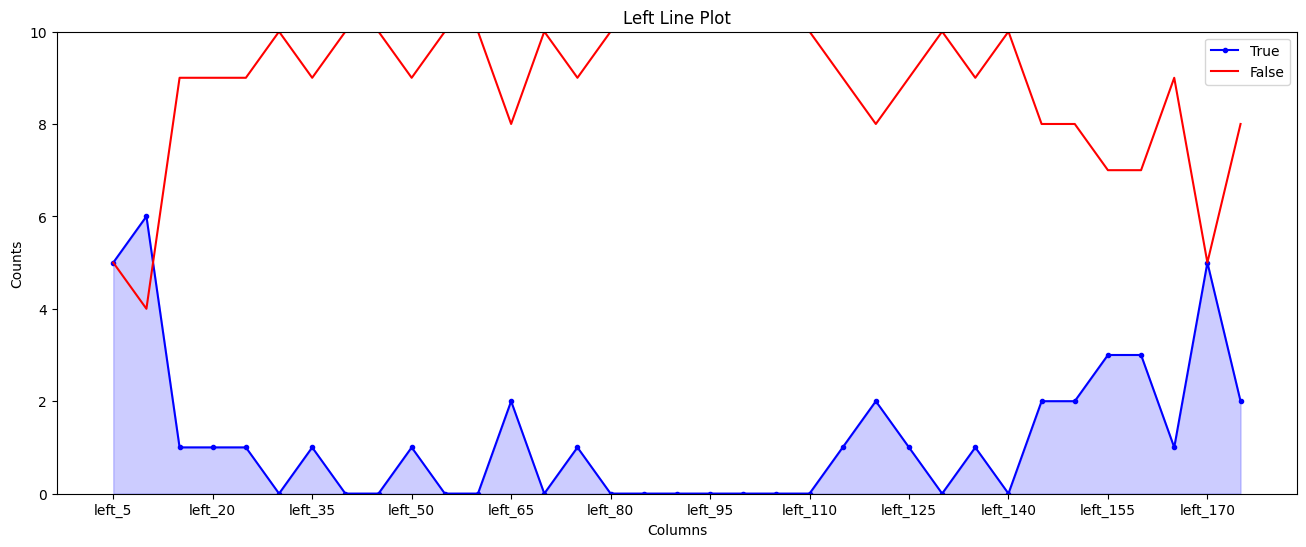

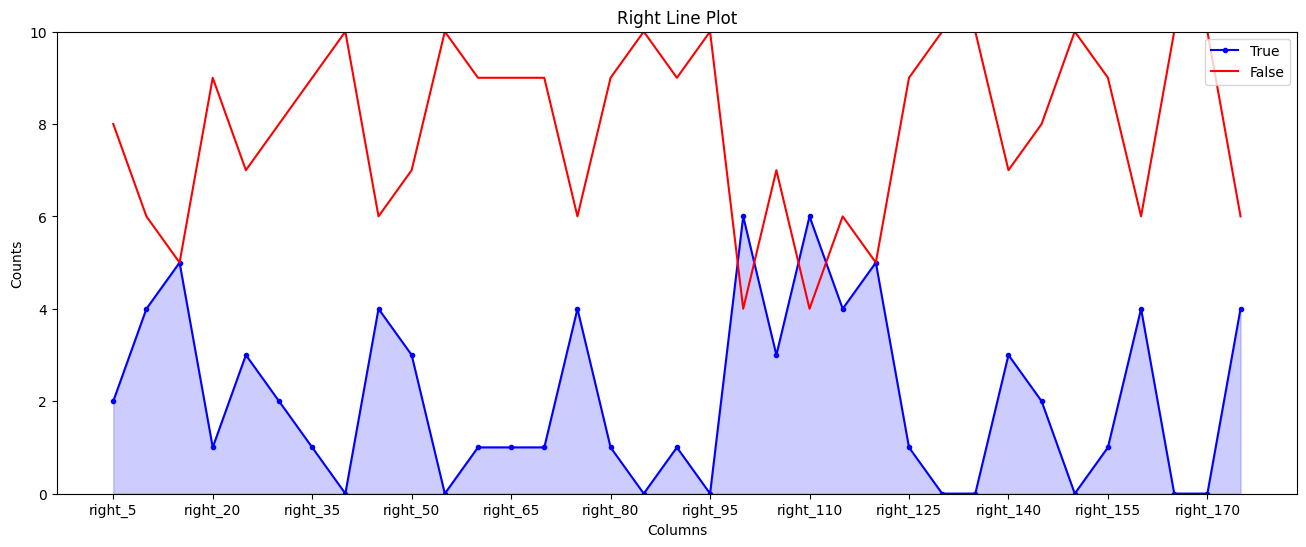

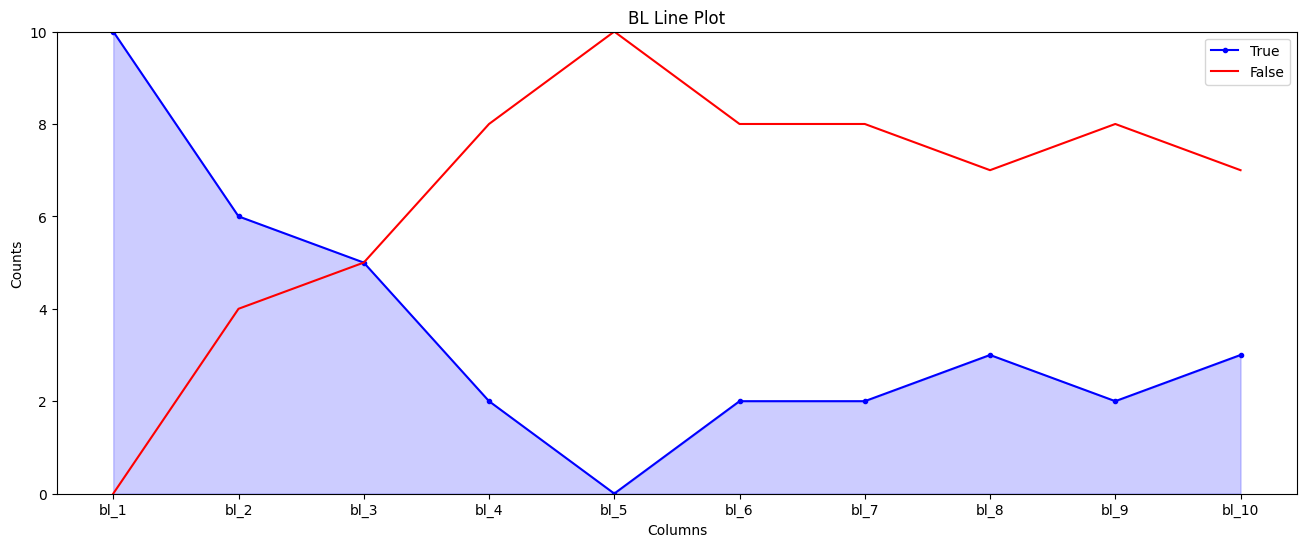

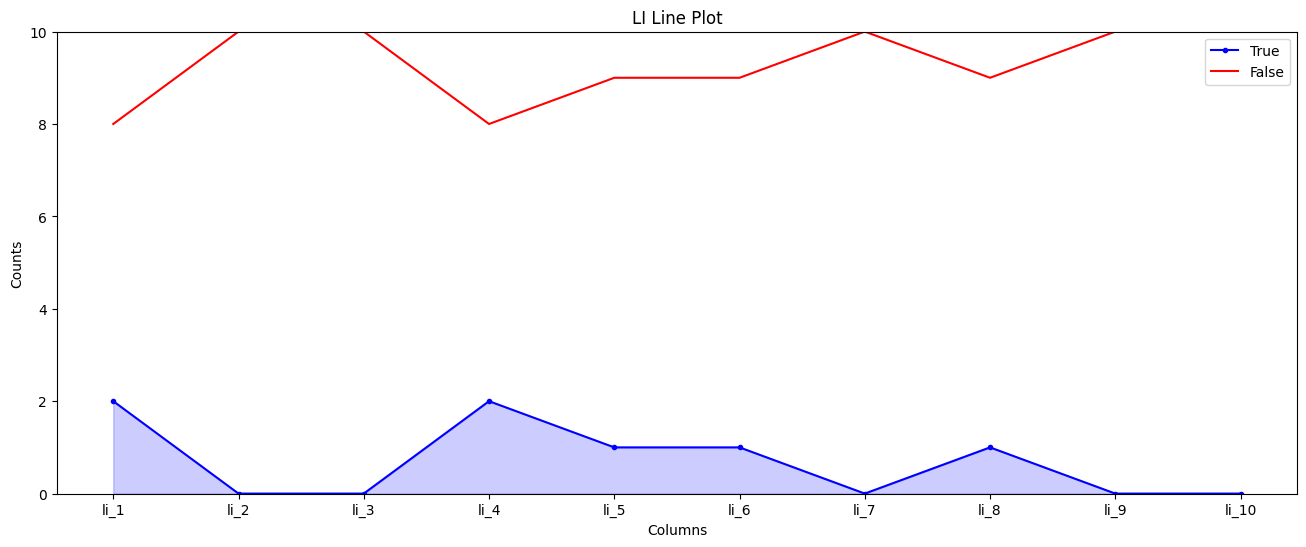

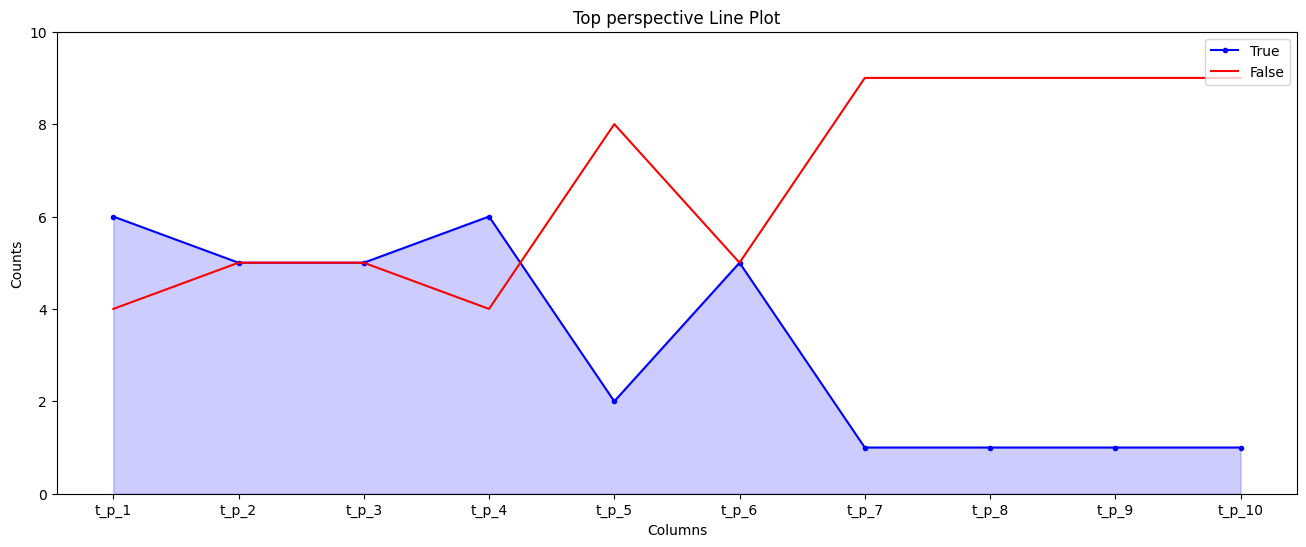

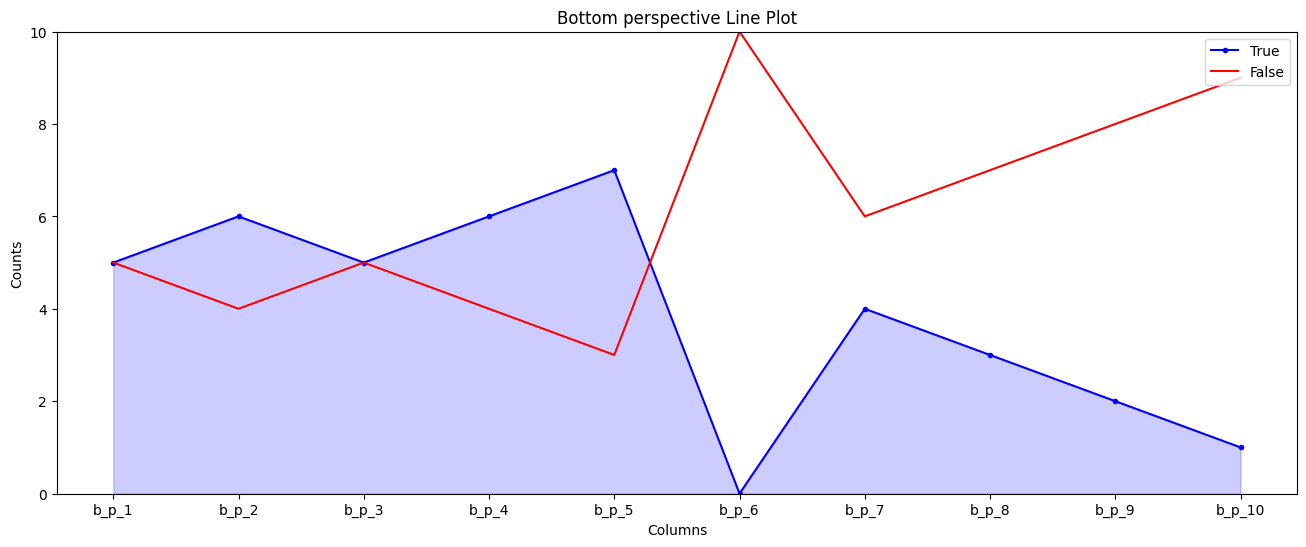

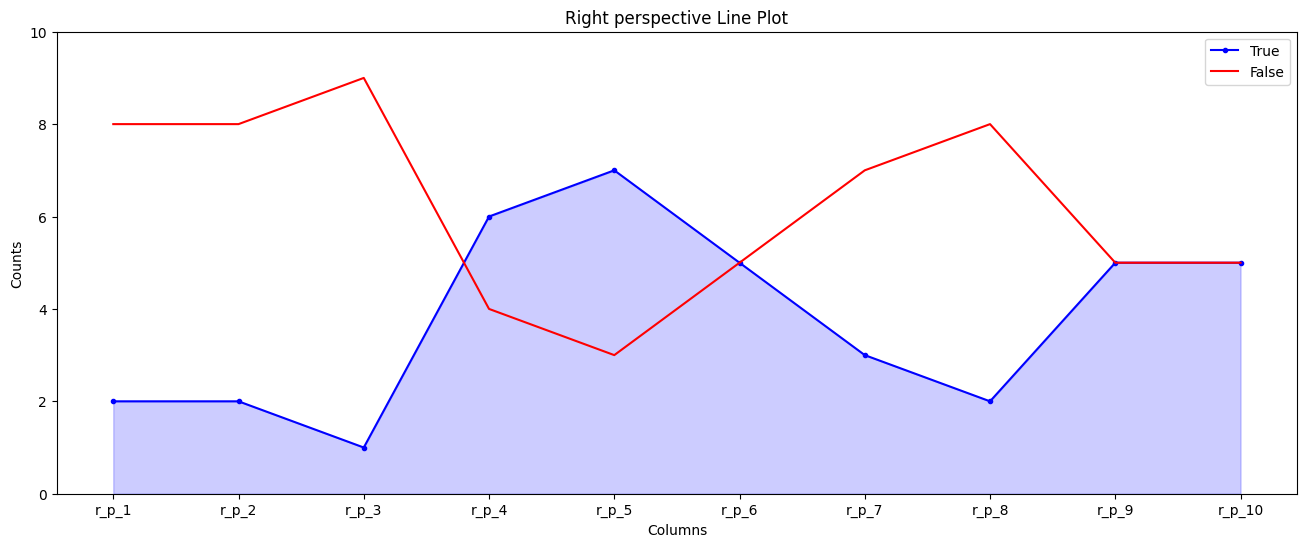

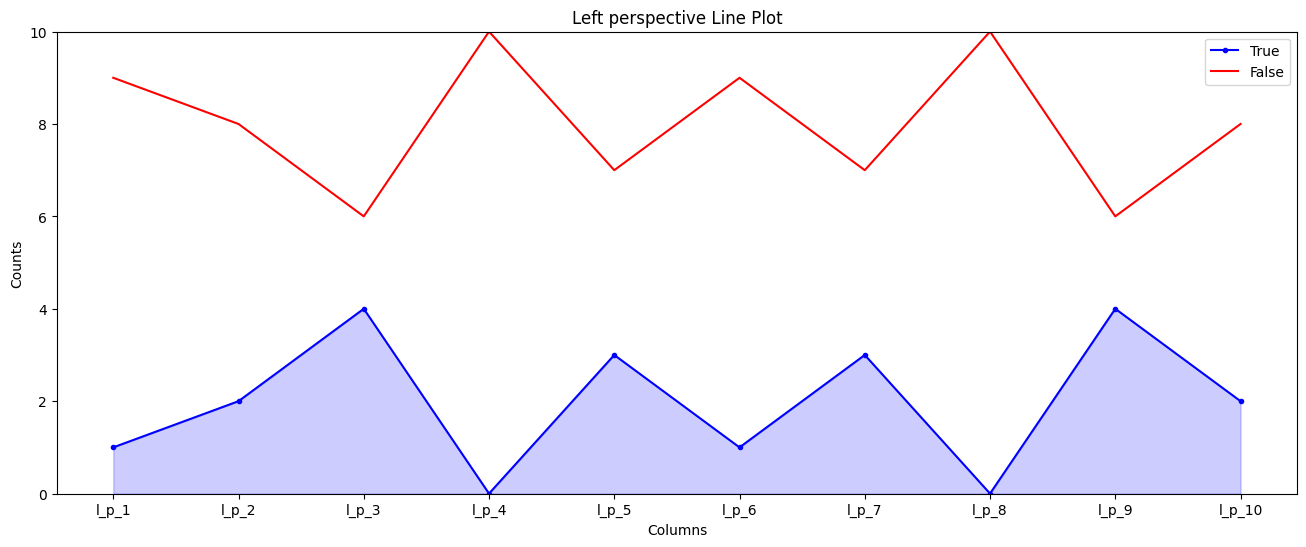

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# LinePlotCreator 클래스 정의
class LinePlotCreator:
    def __init__(self, data_file_path):
        # CSV 파일을 읽어와 데이터프레임으로 저장
        self.df = pd.read_csv(data_file_path, index_col=0).reset_index()
        # True를 1로, False를 0으로 변환
        self.df = self.df.replace({True: 1, False: 0})

    # 열의 0과 1의 개수를 계산하여 반환하는 함수
    def get_column_counts(self, columns):
        zero_counts = (columns == 0).sum()
        one_counts = (columns == 1).sum()
        return zero_counts, one_counts

    # Line Plot을 생성하는 함수
    def create_line_plot(self, data, zero_data, header_labels, title):
        fig, ax = plt.subplots(figsize=(16, 6))

        x = np.arange(len(data))
        ax.plot(x, data, marker='.', label='True', color='blue')

        y = np.arange(len(zero_data))
        ax.plot(y, zero_data, label='False', color='red')

        ax.fill_between(x, 0, data, color='blue', alpha=0.2)

        if title == 'BL Line Plot' or title == 'LI Line Plot' or title == 'Top perspective Line Plot' or title == 'Bottom perspective Line Plot' \
        or title == 'Right perspective Line Plot' or title == 'Left perspective Line Plot':
            ax.set_xticks(x)
            ax.set_xticklabels(header_labels)
            ax.set_xticks(y)
            ax.set_xticklabels(header_labels)

        else:
            tick_positions = np.arange(0, len(data), 3)
            ax.set_xticks(tick_positions)
            ax.set_xticklabels(header_labels[::3])  # 3개마다 1개씩 표시
            tick_positions_2 = np.arange(0, len(zero_data), 3)
            ax.set_xticks(tick_positions_2)
            ax.set_xticklabels(header_labels[::3])  # 3개마다 1개씩 표시

        ax.set_xlabel('Columns')
        ax.set_ylabel('Counts')
        ax.set_title(title)
        ax.legend(labels=['True', 'False'], loc='upper right')

        ax.set_ylim(0, 10)

        return fig

%matplotlib inline

if __name__ == '__main__':
    result_type = ['people_result', 'light_result', 'sign_result']
    result_model = int(input('0: 사람, 1: 신호등, 2: 표지판 > '))
    data_file_path = f'/content/drive/MyDrive/위험객체탐지/{result_type[result_model]}/System_analysis.csv'
    plot_creator = LinePlotCreator(data_file_path)

    # 데이터프레임에서 필요한 열 범위 선택
    left_columns = plot_creator.df.loc[:, 'left_5':'left_175']
    right_columns = plot_creator.df.loc[:, 'right_5':'right_175']
    bl_columns = plot_creator.df.loc[:, 'bl_1':'bl_10']
    li_columns = plot_creator.df.loc[:, 'li_1':'li_10']
    t_p_columns = plot_creator.df.loc[:, 't_p_1':'t_p_10']
    b_p_columns = plot_creator.df.loc[:, 'b_p_1':'b_p_10']
    r_p_columns = plot_creator.df.loc[:, 'r_p_1':'r_p_10']
    l_p_columns = plot_creator.df.loc[:, 'l_p_1':'l_p_10']

    # 열의 0과 1의 개수 계산
    left_zero_counts, left_one_counts = plot_creator.get_column_counts(left_columns)
    right_zero_counts, right_one_counts = plot_creator.get_column_counts(right_columns)
    bl_zero_counts, bl_one_counts = plot_creator.get_column_counts(bl_columns)
    li_zero_counts, li_one_counts = plot_creator.get_column_counts(li_columns)
    t_p_zero_counts, t_p_one_counts = plot_creator.get_column_counts(t_p_columns)
    b_p_zero_counts, b_p_one_counts = plot_creator.get_column_counts(b_p_columns)
    r_p_zero_counts, r_p_one_counts = plot_creator.get_column_counts(r_p_columns)
    l_p_zero_counts, l_p_one_counts = plot_creator.get_column_counts(l_p_columns)

    # 열 이름 헤더 생성
    left_header_labels = ['left_' + str(i) for i in range(5, 176, 5)]
    right_header_labels = ['right_' + str(i) for i in range(5, 176, 5)]
    bl_header_labels = ['bl_' + str(i) for i in range(1, 11)]
    li_header_labels = ['li_' + str(i) for i in range(1, 11)]
    t_p_header_labels = ['t_p_' + str(i) for i in range(1, 11)]
    b_p_header_labels = ['b_p_' + str(i) for i in range(1, 11)]
    r_p_header_labels = ['r_p_' + str(i) for i in range(1, 11)]
    l_p_header_labels = ['l_p_' + str(i) for i in range(1, 11)]

    # Line Plot 생성
    fig_left = plot_creator.create_line_plot(left_one_counts, left_zero_counts, left_header_labels, 'Left Line Plot')
    fig_right = plot_creator.create_line_plot(right_one_counts, right_zero_counts, right_header_labels, 'Right Line Plot')
    fig_bl = plot_creator.create_line_plot(bl_one_counts, bl_zero_counts, bl_header_labels, 'BL Line Plot')
    fig_li = plot_creator.create_line_plot(li_one_counts, li_zero_counts, li_header_labels, 'LI Line Plot')
    fig_t_p = plot_creator.create_line_plot(t_p_one_counts, t_p_zero_counts, t_p_header_labels, 'Top perspective Line Plot')
    fig_b_p = plot_creator.create_line_plot(b_p_one_counts, b_p_zero_counts, b_p_header_labels, 'Bottom perspective Line Plot')
    fig_r_p = plot_creator.create_line_plot(r_p_one_counts, r_p_zero_counts, r_p_header_labels, 'Right perspective Line Plot')
    fig_l_p = plot_creator.create_line_plot(l_p_one_counts, l_p_zero_counts, l_p_header_labels, 'Left perspective Line Plot')

    plt.show()

    # 그래프를 이미지로 저장
    # fig_left.savefig('left_line_chart.png', dpi=100, bbox_inches='tight', pad_inches=0.1)
    # fig_right.savefig('right_line_chart.png', dpi=100, bbox_inches='tight', pad_inches=0.1)
    # fig_bl.savefig('bl_line_chart.png', dpi=100, bbox_inches='tight', pad_inches=0.1)
    # fig_li.savefig('li_line_chart.png', dpi=100, bbox_inches='tight', pad_inches=0.1)